In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader

from datasets import load_dataset

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


import math
from tqdm import tqdm

# creates image and mask transforms. Can discuss hyperparameters later, but we have 256 x 256 images, and normalize to [-1, 1]
IMG_SIZE = 256

image_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

mask_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.PILToTensor(),
])

# Helpful methods for visualizing the images and masks

def visualize_mask(mask: Image, img: Image = None):
    """
    Visualizes the segmentation mask. If an image is provided, it overlays the mask on the image.

    :param mask: The segmentation mask to visualize. Expects a pillow image
    :param img: The image to overlay the mask on. Expects a pillow image
    :return:
    """
    mask_np = np.array(mask)

    class_colors = {
        1: [255, 0, 0],    # red for prediction
        2: [0, 255, 0],    # green for background
        3: [0, 0, 255],    # blue for ambiguous
    }

    h, w = mask_np.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for class_id, color in class_colors.items():
        color_mask[mask_np == class_id] = color

    if img is not None:
        img = img.convert('RGBA')
        overlay = Image.fromarray(color_mask).convert('RGBA')
        blended = Image.blend(img, overlay, alpha=0.5)

        plt.figure(figsize=(6, 6))
        plt.imshow(blended)
        plt.title('Segmentation Overlay')
        plt.axis('off')
        plt.show()
    else:
        plt.figure(figsize=(6, 6))
        plt.imshow(color_mask)
        plt.title('Colorized Segmentation Mask')
        plt.axis('off')
        plt.show()

def visualize_mask_tensor(img_tensor: torch.Tensor, mask_tensor: torch.Tensor, alpha: float = 0.5, title: str = "Image Mask"):
    """
    Overlays a mask tensor onto an image tensor and displays the result.

    :param img_tensor: Image tensor of shape (C, H, W)
    :param mask_tensor: Mask tensor of shape (H, W)
    :param mode: 'class' or 'category'
    :param alpha: Transparency for overlay
    """
    img_np = img_tensor.permute(1, 2, 0).numpy()
    mask_np = mask_tensor.numpy()

    h, w = mask_np.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)

    color_mask[mask_np == 1] = [255, 0, 0]   # red for mask
    color_mask[mask_np == 2] = [0, 0, 255]   # blue for bg

    plt.figure(figsize=(6, 6))
    plt.imshow(img_np)
    plt.imshow(color_mask, alpha=alpha)
    plt.axis('off')
    plt.title(title)
    plt.show()


class_labels = ['cat', 'dog']
category_labels = ['Abyssinian', 'american bulldog', 'american pit bull terrier', 'basset hound', 'beagle', 'Bengal', 'Birman', 'Bombay',
          'boxer', 'British Shorthair', 'chihuahua', 'Egyptian Mau', 'english cocker spaniel', 'english setter', 'german shorthaired', 'great pyrenees', 'havanese', 'japanese chin', 'keeshond', 'leonberger', 'Maine Coon', 'miniature pinscher', 'newfoundland',
          'Persian', 'pomeranian', 'pug', 'Ragdoll', 'Russian Blue', 'saint bernard', 'samoyed', 'scottish terrier', 'shiba inu', 'Siamese',
          'Sphynx', 'staffordshire bull terrier', 'wheaten terrier', 'yorkshire terrier']

# the index of these lists relate to the label that is associate with an image

def transform_class_example(example: dict, include_ambiguous: bool = False) -> dict:
    """
    Transforms the image and mask in from a given example

    :param example: an example from a hf dataset; a dictionary with keys from the dataset
    :param include_ambiguous: whether to include the ambiguous class in the mask.
      If true, the ambiguous class is included in the mask. If false, the ambiguous class is removed from the mask (background).

    :return: a dictionary with the transformed image and mask
    """
    class_label = example['class']
    mask = mask_transform(example["msk"]).squeeze(0)

    mask[mask == 0] = 2
    mask[mask == 1] = 0
    mask[mask == 2] = 1
    if include_ambiguous:
        mask[mask == 3] = 1
    else:
        mask[mask == 3] = 0

    return {
        "image": image_transform(example["img"]),
        "mask": mask,
        "classification": class_label
    }

def transform_category_example(example: dict, include_ambiguous: bool = False) -> dict:
    """
    Transforms the image and mask in from a given example

    :param example: an example from a hf dataset; a dictionary with keys from the dataset
    :param include_ambiguous: whether to include the ambiguous class in the mask.
      If true, the ambiguous class is included in the mask. If false, the ambiguous class is removed from the mask (background).
    :return: a dictionary with the transformed image and mask
    """
    category_label = example['category']
    mask = mask_transform(example["msk"]).squeeze(0)

    # switch 0 and 1. Now 0 is background and 1 is the mask
    mask[mask == 0] = 2
    mask[mask == 1] = 0
    mask[mask == 2] = 1
    if include_ambiguous:
        mask[mask == 3] = 1
    else:
        mask[mask == 3] = 0


    # here we are switching around the values from the original dataset. Instead of having 0 be foreground, it becomes the vaue
    # of the category number, the background becomes 37 and ambiguous becomes 38
    return {
        "image": image_transform(example["img"]),
        "mask": mask,
        "classification": category_label
    }

def generate_dataset(split: str, classification: str = 'class'):
    """
    Generates a dataset for the given split and classification type.

    :param split: which split to generate. Can be train, test or valid
    :param mask: decides whether to use the mask, or the class label
    :param classification: Can either be class or category. Class is either cat or dog, while category is the breed.
    :return: a dataset of the given split. With transformed images and masks.
    """
    if split not in ['test', 'train', 'valid']:
        raise ValueError('Split must be either test train or valid')
    if classification not in ['class', 'category']:
        raise ValueError('Classification must be either class or category. Class is either cat or dog, while category is the breed.')

    dataset = load_dataset('cvdl/oxford-pets', split=split)

    # remove the bbox and non-used classification columns
    if classification == 'class':
        dataset = dataset.map(transform_class_example, remove_columns=['bbox', 'img', 'msk', 'category', 'class'])
    elif classification == 'category':
        dataset = dataset.map(transform_category_example, remove_columns=['bbox', 'img', 'msk', 'class', 'category'])

    dataset.set_format(type='torch', columns=['image', 'mask', 'classification'])

    # transform the images and masks
    return dataset

train_set = generate_dataset('train', classification='class')
test_set = generate_dataset('test', classification='class')

In [2]:
mask = True
batch_size = 32

train_loader = DataLoader(train_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)


In [3]:
class ConvNN(nn.Module):
    def __init__(self, num_classes=4):
        super(ConvNN, self).__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(3, 16, 11, stride=1, padding='same')
        self.conv2 = nn.Conv2d(16, 32, 11, stride=1, padding='same')
        self.conv3 = nn.Conv2d(32, 64, 3, stride=1, padding='same')
        self.conv4 = nn.Conv2d(64, 128, 3, stride=1, padding='same')
        self.conv5 = nn.Conv2d(128, num_classes, kernel_size=1)
        self.conv5 = nn.Conv2d(128, 256, 3, stride=1, padding='same')
        self.conv6 = nn.Conv2d(256, 512, 3, stride=1, padding='same')
        self.conv7 = nn.Conv2d(512, 1024, 3, stride=1, padding='same')
        self.conv8 = nn.Conv2d(1024, num_classes, kernel_size=1)
        self.pool = nn.MaxPool2d(2, 2)


    def forward(self, x):
        original_size = x.shape[2:]

        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.relu(self.conv7(x))
        x = self.conv8(x)
        # x = self.conv2(x)

        x = F.interpolate(x, size=original_size)

        return x


In [4]:
model = ConvNN(num_classes=2)
model.load_state_dict(torch.load("animals_cnn_epoch_100.pth", weights_only=False))
model.eval()

ConvNN(
  (relu): ReLU()
  (conv1): Conv2d(3, 16, kernel_size=(11, 11), stride=(1, 1), padding=same)
  (conv2): Conv2d(16, 32, kernel_size=(11, 11), stride=(1, 1), padding=same)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv7): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv8): Conv2d(1024, 2, kernel_size=(1, 1), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [5]:
diff = 0
total = 0

with torch.no_grad():
    for idx, value in tqdm(enumerate(test_loader)):
        output = model(value['image'])
        batch_pred = output.max(1, keepdim=True)[1]
        for p, ans in zip(batch_pred, value['mask']):
            pred = p[0]
            print(pred.shape, ans.shape)
            diff += (torch.abs(pred-ans) != 0).sum()
            total += torch.numel(ans)
        # correct += pred.eq(target.view_as(pred)).sum().item()
        break

test_acc = 1 - diff/total
test_acc

0it [00:15, ?it/s]

torch.Size([256, 256]) torch.Size([256, 256])
torch.Size([256, 256]) torch.Size([256, 256])
torch.Size([256, 256]) torch.Size([256, 256])
torch.Size([256, 256]) torch.Size([256, 256])
torch.Size([256, 256]) torch.Size([256, 256])
torch.Size([256, 256]) torch.Size([256, 256])
torch.Size([256, 256]) torch.Size([256, 256])
torch.Size([256, 256]) torch.Size([256, 256])
torch.Size([256, 256]) torch.Size([256, 256])
torch.Size([256, 256]) torch.Size([256, 256])
torch.Size([256, 256]) torch.Size([256, 256])
torch.Size([256, 256]) torch.Size([256, 256])
torch.Size([256, 256]) torch.Size([256, 256])
torch.Size([256, 256]) torch.Size([256, 256])
torch.Size([256, 256]) torch.Size([256, 256])
torch.Size([256, 256]) torch.Size([256, 256])
torch.Size([256, 256]) torch.Size([256, 256])
torch.Size([256, 256]) torch.Size([256, 256])
torch.Size([256, 256]) torch.Size([256, 256])
torch.Size([256, 256]) torch.Size([256, 256])
torch.Size([256, 256]) torch.Size([256, 256])
torch.Size([256, 256]) torch.Size(

tensor(0.8186)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


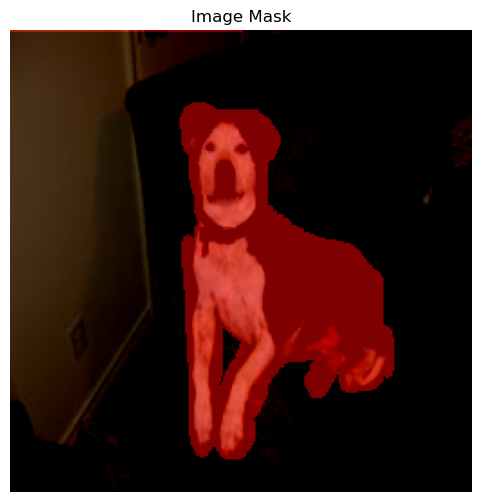

In [6]:
visualize_mask_tensor(value['image'][31], value['mask'][31])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


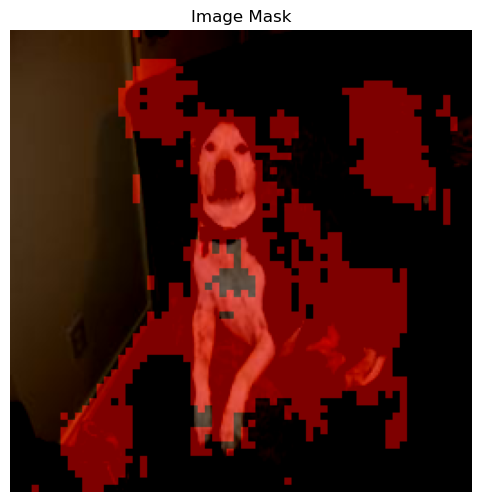

In [7]:
visualize_mask_tensor(value['image'][31], pred)

In [8]:
batch = (next(iter(test_loader)))
batch["image"].shape

torch.Size([32, 3, 256, 256])

In [9]:
output = model(batch["image"])
batch_pred = output.max(1, keepdim=True)[1]

In [13]:
# for p, ans in zip(batch_pred, value['mask']):
i = 15
p = batch_pred[i]
ans = value['mask'][i]
pred = p[0]
print(pred.shape, ans.shape)

torch.Size([256, 256]) torch.Size([256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(7372) 65536


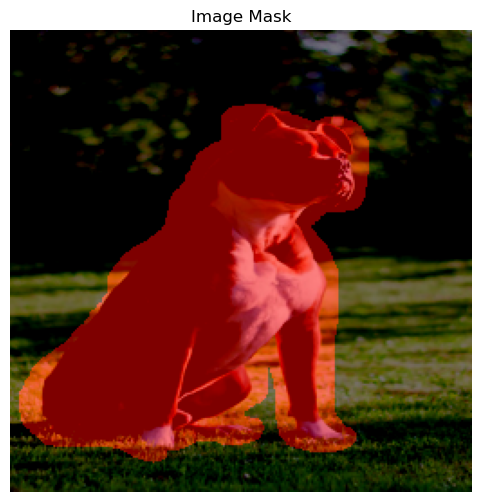

In [14]:
print((torch.abs(pred-ans) != 0).sum(), torch.numel(ans))
visualize_mask_tensor(batch['image'][i], ans)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


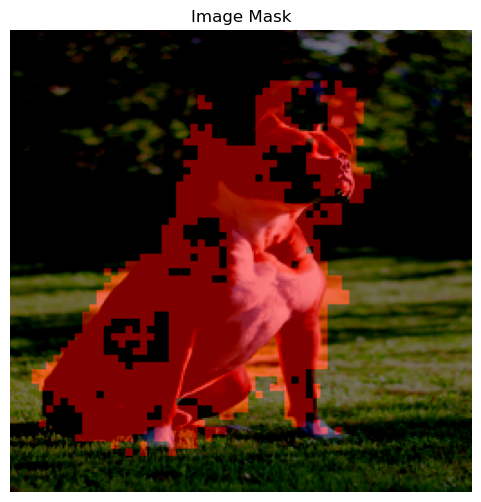

In [15]:
visualize_mask_tensor(batch['image'][i], pred)